In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt \
    -O /tmp/irish-lyrics-eof.txt

In [50]:
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import pickle

**DATA CLEANING AND PREPARATION**

In [2]:
data = open('/tmp/irish-lyrics-eof.txt').read()

In [4]:
data = data.lower().split('\n')

In [ ]:
punc = set(string.punctuation)
print(punc)

In [10]:
for i in range(len(data)):
  st = data[i]
  out_st = ''.join(ch for ch in st if ch not in punc)
  data[i] = out_st

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)

In [18]:
total_words = len(tokenizer.word_index) + 1
print(total_words)

2703


In [20]:
input_seq = []
for line in data:
  st = tokenizer.texts_to_sequences([line])[0]
  for i in range(1,len(st)):
    ngs = st[:i+1]
    input_seq.append(ngs)

In [ ]:
max_seq_length = max([len(st) for st in input_seq])
print(max_seq_length)

In [26]:
input_seq = np.array(pad_sequences(input_seq, maxlen=max_seq_length, padding='pre'))

In [28]:
x_train = input_seq[:,:-1]
y_train = input_seq[:,-1]

In [29]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=total_words)

**MODEL CREATION AND TRAINING**

In [45]:
input = Input(shape=max_seq_length-1)
emb = Embedding(input_dim=total_words, output_dim=120, input_length=max_seq_length-1)(input)
x = Bidirectional(LSTM(256, return_sequences=True))(emb)
x = Bidirectional(LSTM(256, return_sequences=True))(x)
x = Bidirectional(LSTM(256))(x)
x = Dense(128,activation='relu')(x)
output = Dense(total_words,activation='softmax')(x)

model = Model(inputs=[input],outputs=[output])

In [46]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 15, 120)           324360    
                                                                 
 bidirectional_6 (Bidirectio  (None, 15, 512)          772096    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 15, 512)          1574912   
 nal)                                                            
                                                                 
 bidirectional_8 (Bidirectio  (None, 512)              1574912   
 nal)                                                            
                                                             

In [47]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
early_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=0, patience=7, restore_best_weights=True)

In [49]:
history = model.fit(x_train, y_train, epochs = 200, callbacks = [early_callback])

Epoch 1/200
375/375 [==============================] - 30s 45ms/step - loss: 6.7620 - accuracy: 0.0656
Epoch 2/200
375/375 [==============================] - 16s 42ms/step - loss: 6.4304 - accuracy: 0.0661
Epoch 3/200
375/375 [==============================] - 16s 42ms/step - loss: 6.2809 - accuracy: 0.0662
Epoch 4/200
375/375 [==============================] - 17s 44ms/step - loss: 6.1561 - accuracy: 0.0715
Epoch 5/200
375/375 [==============================] - 16s 42ms/step - loss: 5.9964 - accuracy: 0.0797
Epoch 6/200
375/375 [==============================] - 16s 42ms/step - loss: 5.8318 - accuracy: 0.0877
Epoch 7/200
375/375 [==============================] - 16s 42ms/step - loss: 5.6644 - accuracy: 0.1022
Epoch 8/200
375/375 [==============================] - 16s 42ms/step - loss: 5.5124 - accuracy: 0.1083
Epoch 9/200
375/375 [==============================] - 16s 42ms/step - loss: 5.3851 - accuracy: 0.1154
Epoch 10/200
375/375 [==============================] - 16s 42ms/step - l

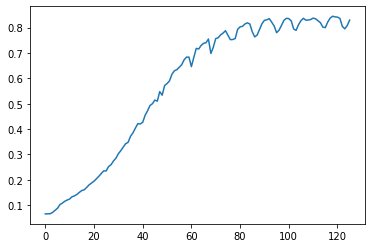

In [51]:
plt.plot(history.history['accuracy'])
plt.show()

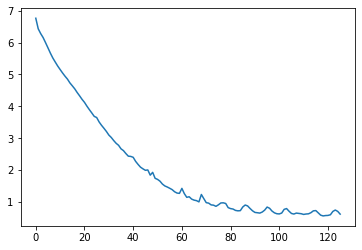

In [52]:
plt.plot(history.history['loss'])
plt.show()

In [54]:
model.save('Model', save_format='h5')

**MODEL TESTING AND OUTPUT GENERATION**

In [80]:
def poetry_gen(model, st, tokenizer, n_words, max_seq_length):
  ex = string.punctuation
  #out_st = ''.join(ch for ch in st if ch not in punc)
  st = ''.join(ch.lower() for ch in st if ch not in ex)
  for i in range(n_words):
    seq = tokenizer.texts_to_sequences([st])[0]
    seq = np.array(pad_sequences([seq],maxlen=max_seq_length-1,padding='pre'))
    output = np.argmax(model.predict(seq),axis=1)
    word = ""
    for w, index in tokenizer.word_index.items():
      if index==output:
        word=w
        break
    st += " " + word
  return st

In [82]:
seed_text = 'Come all ye maidens young and fair'
n_words = 20
output = poetry_gen(model, seed_text, tokenizer, n_words, max_seq_length)
print(output)

come all ye maidens young and fair early was in peggy found from rosin the bow moved no wonder we daughter so were you love me and


In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)